In [2]:
#import needed libraries

#processing:

import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
from queryCarto import *
import matplotlib.pyplot as plt

#system:

import os
from urllib.request import urlretrieve
import urllib.request as urllib
import urllib as urli

#modeling:

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from FeatureImportancePlotter import *

%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Data gathering and wrangling

In [3]:
#get SAT score file from NYC Open data. Found here: https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4

url = 'https://data.cityofnewyork.us/api/views/f9bf-2cp4/rows.csv?accessType=DOWNLOAD'
urlretrieve(url,'2012_SAT_Results.csv')

('2012_SAT_Results.csv', <http.client.HTTPMessage at 0x7efc83b0b2b0>)

In [4]:
#move SAT results file to PUI data

!mv 2012_SAT_Results.csv $PUIDATA

In [5]:
#load file in using pandas

sat_scores = pd.read_csv(os.getenv("PUIDATA")+'/'+'2012_SAT_Results.csv')

In [6]:
#visualize the sat_scores data set
sat_scores.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384


In [7]:
#check data types
sat_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478 entries, 0 to 477
Data columns (total 6 columns):
DBN                                478 non-null object
SCHOOL NAME                        478 non-null object
Num of SAT Test Takers             478 non-null object
SAT Critical Reading Avg. Score    478 non-null object
SAT Math Avg. Score                478 non-null object
SAT Writing Avg. Score             478 non-null object
dtypes: object(6)
memory usage: 22.5+ KB


In [8]:
#drop the "s" values from 
sat_scores = sat_scores[sat_scores['SAT Critical Reading Avg. Score'] != 's']

#spot check to make sure the "s" are gone so I can convert to a number
sat_scores

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384
5,01M515,LOWER EAST SIDE PREPARATORY HIGH SCHOOL,112,332,557,316
6,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522,574,525
7,01M650,CASCADES HIGH SCHOOL,18,417,418,411
8,01M696,BARD HIGH SCHOOL EARLY COLLEGE,130,624,604,628
9,02M047,47 THE AMERICAN SIGN LANGUAGE AND ENGLISH SECO...,16,395,400,387


In [9]:
#convert scores to numeric values
sat_scores['SAT Critical Reading Avg. Score'] = pd.to_numeric(sat_scores['SAT Critical Reading Avg. Score'])
sat_scores['SAT Math Avg. Score'] = pd.to_numeric(sat_scores['SAT Math Avg. Score'])
sat_scores['SAT Writing Avg. Score'] = pd.to_numeric(sat_scores['SAT Writing Avg. Score'])

In [10]:
#take average of three components scores for an overall score
sat_scores['total_score'] = (sat_scores['SAT Critical Reading Avg. Score'] + sat_scores['SAT Math Avg. Score'] +
                            sat_scores['SAT Writing Avg. Score']) / 3

In [11]:
#filter data frame to get only needed columns and export to a csv

sat_scores = sat_scores[['DBN', 'SAT Math Avg. Score', 'total_score']]
sat_scores.to_csv("sat_score.csv", index=False)

In [12]:
#visualize filtered dataframe
sat_scores.head()

,DBN,SAT Math Avg. Score,total_score
0,01M292,404,374.000000
1,01M448,423,390.666667
2,01M450,402,383.000000
3,01M458,401,391.333333
4,01M509,433,402.333333


In [13]:
sat_scores.shape

(421, 3)

##### read in the NYPD crimes in school report

In [14]:
#read in the school safety report file from NYC open data, 
#found here: https://data.cityofnewyork.us/Education/2010-2016-School-Safety-Report/qybk-bjjc

url2 = 'https://data.cityofnewyork.us/api/views/qybk-bjjc/rows.csv?accessType=DOWNLOAD'
urlretrieve(url2,'2010-2016_School_Safety_Report.csv')

('2010-2016_School_Safety_Report.csv',
 <http.client.HTTPMessage at 0x7efc83a67cf8>)

In [15]:
#move school safety data results file to PUI data

!mv 2010-2016_School_Safety_Report.csv $PUIDATA

In [16]:
#load file in using pandas

school_safety = pd.read_csv(os.getenv("PUIDATA")+'/'+'2010-2016_School_Safety_Report.csv')

#visualize head
school_safety.head()

,School Year,Building Code,DBN,Location Name,Location Code,Address,Borough,Geographical District Code,Register,Building Name,...,Borough Name,Postcode,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA
0,2013-14,K001,15K001,P.S. 001 The Bergen,K001,309 47 STREET,K,15.0,"1,277",NaN,...,BROOKLYN,11220.0,40.649042,-74.012289,7.0,38.0,80.0,3011821.0,3.007550e+09,Sunset Park West ...
1,2013-14,K002,17K002,Parkside Preparatory Academy,K002,655 PARKSIDE AVENUE,K,17.0,479,655 PARKSIDE AVENUE CONSOLIDATED LOCATION,...,BROOKLYN,11226.0,40.656183,-73.951583,9.0,40.0,802.0,3378201.0,3.050500e+09,Prospect Lefferts Gardens-Wingate ...
2,2013-14,K002,75K141,P.S. K141,K141,655 PARKSIDE AVENUE,K,17.0,397,655 PARKSIDE AVENUE CONSOLIDATED LOCATION,...,BROOKLYN,11226.0,40.656183,-73.951583,9.0,40.0,802.0,3378201.0,3.050500e+09,Prospect Lefferts Gardens-Wingate ...
3,2013-14,K002,84K704,Explore Charter School,K704,655 PARKSIDE AVENUE,K,17.0,NaN,655 PARKSIDE AVENUE CONSOLIDATED LOCATION,...,BROOKLYN,11226.0,40.656183,-73.951583,9.0,40.0,802.0,3378201.0,3.050500e+09,Prospect Lefferts Gardens-Wingate ...
4,2013-14,K002,NaN,655 PARKSIDE AVENUE CONSOLIDATED LOCATION,NaN,655 PARKSIDE AVENUE,K,17.0,876,655 PARKSIDE AVENUE CONSOLIDATED LOCATION,...,BROOKLYN,11226.0,40.656183,-73.951583,9.0,40.0,802.0,3378201.0,3.050500e+09,Prospect Lefferts Gardens-Wingate ...


In [17]:
#check columns
school_safety.columns

Index(['School Year', 'Building Code', 'DBN', 'Location Name', 'Location Code',
       'Address', 'Borough', 'Geographical District Code', 'Register',
       'Building Name', '# Schools', 'Schools in Building', 'Major N', 'Oth N',
       'NoCrim N', 'Prop N', 'Vio N', 'ENGroupA', 'RangeA', 'AvgOfMajor N',
       'AvgOfOth N', 'AvgOfNoCrim N', 'AvgOfProp N', 'AvgOfVio N',
       'Borough Name', 'Postcode', 'Latitude', 'Longitude', 'Community Board',
       'Council District ', 'Census Tract', 'BIN', 'BBL', 'NTA'],
      dtype='object')

In [18]:
#check column types
school_safety.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6310 entries, 0 to 6309
Data columns (total 34 columns):
School Year                   6310 non-null object
Building Code                 6310 non-null object
DBN                           5308 non-null object
Location Name                 6310 non-null object
Location Code                 5308 non-null object
Address                       6308 non-null object
Borough                       6308 non-null object
Geographical District Code    6304 non-null float64
Register                      6050 non-null object
Building Name                 3756 non-null object
# Schools                     6310 non-null int64
Schools in Building           6310 non-null object
Major N                       3561 non-null float64
Oth N                         3561 non-null float64
NoCrim N                      3561 non-null float64
Prop N                        3561 non-null float64
Vio N                         3561 non-null float64
ENGroupA             

##### inspect the distribution of crimes per school

In [19]:
#create a column of crime in the school by summing major and minor crimes
school_safety['all_crime'] = school_safety['Major N'] + school_safety['Oth N']

#calculate number of crimes per school based on number of schools in the building, just in case this impacts the distribution
school_safety['crime_persch'] = school_safety['all_crime'] / school_safety['# Schools']

In [20]:
#fill na values before graphing

school_safety['all_crime'].fillna(value=0,inplace=True)
school_safety['crime_persch'].fillna(value=0,inplace=True)

Text(0.5,1,'Histogram of Number of Major+Other Crimes per School, 2010-2016')

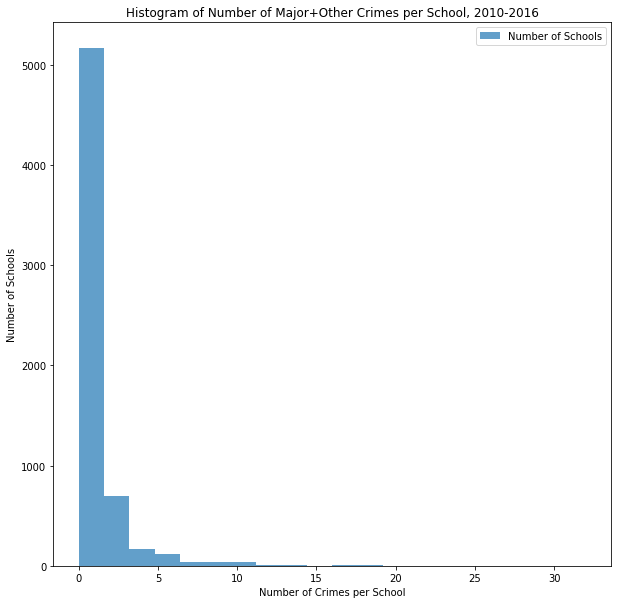

In [21]:
fig = plt.figure(figsize=(10,10)) #initialize figure
ax = fig.add_subplot(111) #initialize subplot

ax.hist(school_safety['crime_persch'], bins=20, alpha=0.7, label="Number of Schools")

plt.xlabel("Number of Crimes per School") #x label added
plt.ylabel("Number of Schools") #add Y label
plt.legend(loc = "upper right") #add legend
plt.title("Histogram of Number of Major+Other Crimes per School, 2010-2016")

In [22]:
#fill nan's in avg major crimes column before plotting
school_safety['AvgOfMajor N'].fillna(value=0,inplace=True)

Text(0.5,1,'Histogram of Average Number of Major Crimes by School in NYC, 2010-2016')

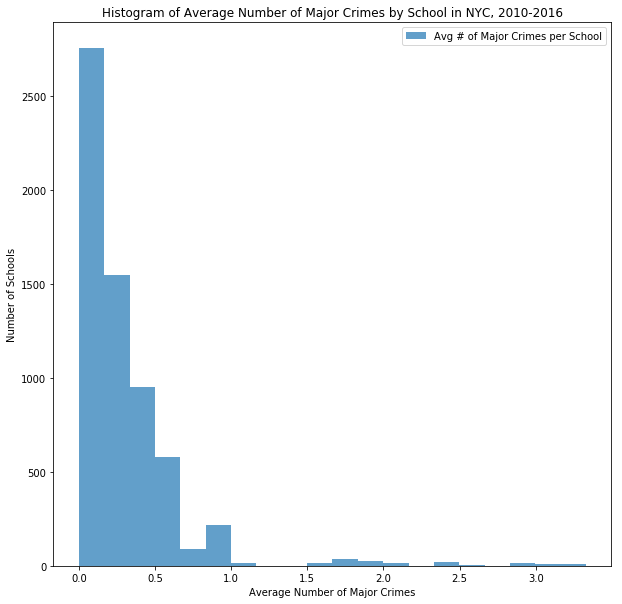

In [23]:
# plot the distribution of "Average number of Major" crimes by school

fig = plt.figure(figsize=(10,10)) #initialize figure
ax = fig.add_subplot(111) #initialize subplot

ax.hist(school_safety['AvgOfMajor N'], bins=20, alpha=0.7, label="Avg # of Major Crimes per School")

plt.xlabel("Average Number of Major Crimes") #x label added
plt.ylabel("Number of Schools") #add Y label
plt.legend(loc = "upper right") #add legend
plt.title("Histogram of Average Number of Major Crimes by School in NYC, 2010-2016")


### Figure 2: Histogram of Average Number of Major Crimes by School in NYC, 2010-2016
#### Figure 2 shows a histogram of the average number of major crimes by school for the 2010-2016 period. In this instance, NaN values in the dataframe are filled with zero values, since I am assuming this means no major crime occurred at the school. What the histogram shows is that most schools in the city do not have major crimes occurring and that there are a few outliers schools where there is a high incidence of average major cimes (above 1.5)

In [24]:
#reduce the crime dataframe

school_safety =  school_safety[['School Year', 'DBN','# Schools', 'Major N', 'Oth N',
       'NoCrim N', 'Prop N', 'Vio N', 'ENGroupA', 'RangeA', 'AvgOfMajor N',
       'AvgOfOth N', 'AvgOfNoCrim N', 'AvgOfProp N', 'AvgOfVio N',
       'Borough Name', 'Latitude', 'Longitude']]

In [25]:
school_safety.head()

,School Year,DBN,# Schools,Major N,Oth N,NoCrim N,Prop N,Vio N,ENGroupA,RangeA,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,Borough Name,Latitude,Longitude
0,2013-14,15K001,1,0.0,2.0,1.0,1.0,0.0,7C,1251-1500,0.86,3.26,5.55,2.17,1.29,BROOKLYN,40.649042,-74.012289
1,2013-14,17K002,3,NaN,NaN,NaN,NaN,NaN,3C,251-500,0.00,NaN,NaN,NaN,NaN,BROOKLYN,40.656183,-73.951583
2,2013-14,75K141,3,NaN,NaN,NaN,NaN,NaN,3C,251-500,0.00,NaN,NaN,NaN,NaN,BROOKLYN,40.656183,-73.951583
3,2013-14,84K704,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,BROOKLYN,40.656183,-73.951583
4,2013-14,NaN,3,1.0,5.0,2.0,2.0,4.0,5C,751-1000,0.52,1.71,2.49,1.16,0.75,BROOKLYN,40.656183,-73.951583


In [26]:
school_safety['School Year'].unique()

array(['2013-14', '2014-15', '2015-16'], dtype=object)

In [27]:
school_safety = school_safety[school_safety['School Year'] == '2013-14']

In [28]:
#check shape of dataframes
print("school safety shape = {}".format(school_safety.shape), "sat scores shape = {}".format(sat_scores.shape))

school safety shape = (2159, 18) sat scores shape = (421, 3)


In [29]:
schools = pd.merge(left=school_safety,right=sat_scores,how='outer',left_on='DBN',right_on='DBN')
schools.head()

,School Year,DBN,# Schools,Major N,Oth N,NoCrim N,Prop N,Vio N,ENGroupA,RangeA,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,Borough Name,Latitude,Longitude,SAT Math Avg. Score,total_score
0,2013-14,15K001,1.0,0.0,2.0,1.0,1.0,0.0,7C,1251-1500,0.86,3.26,5.55,2.17,1.29,BROOKLYN,40.649042,-74.012289,NaN,NaN
1,2013-14,17K002,3.0,NaN,NaN,NaN,NaN,NaN,3C,251-500,0.00,NaN,NaN,NaN,NaN,BROOKLYN,40.656183,-73.951583,NaN,NaN
2,2013-14,75K141,3.0,NaN,NaN,NaN,NaN,NaN,3C,251-500,0.00,NaN,NaN,NaN,NaN,BROOKLYN,40.656183,-73.951583,NaN,NaN
3,2013-14,84K704,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,BROOKLYN,40.656183,-73.951583,NaN,NaN
4,2013-14,NaN,3.0,1.0,5.0,2.0,2.0,4.0,5C,751-1000,0.52,1.71,2.49,1.16,0.75,BROOKLYN,40.656183,-73.951583,NaN,NaN


In [30]:
schools.shape

(2168, 20)

In [31]:
#first, drop rows where there are no sat scores, using total score for this drop which should pick them all up

schools.dropna(subset=['total_score'],inplace=True)
schools.shape

(422, 20)

In [32]:
#next, fill in missing crime data with 0, since we can assume no entries meant no crime.
schools.fillna(0,inplace=True)
schools.head() #check that values were filled in properly

,School Year,DBN,# Schools,Major N,Oth N,NoCrim N,Prop N,Vio N,ENGroupA,RangeA,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,Borough Name,Latitude,Longitude,SAT Math Avg. Score,total_score
395,2013-14,16K393,3.0,0.0,0.0,0.0,0.0,0.0,2C,1-250,0.00,0.00,0.00,0.00,0.00,BROOKLYN,40.692126,-73.931731,355.0,356.000000
405,2013-14,02M418,1.0,0.0,0.0,0.0,0.0,0.0,4C,501-750,0.33,1.32,1.76,0.83,0.59,MANHATTAN,40.704487,-74.011556,553.0,538.000000
414,2013-14,16K594,2.0,0.0,0.0,0.0,0.0,0.0,2C,1-250,0.00,0.00,0.00,0.00,0.00,BROOKLYN,40.680463,-73.922264,372.0,364.333333
423,2013-14,14K586,3.0,0.0,0.0,0.0,0.0,0.0,4C,501-750,0.00,0.00,0.00,0.00,0.00,BROOKLYN,40.709941,-73.943641,377.0,367.666667
424,2013-14,14K454,3.0,0.0,0.0,0.0,0.0,0.0,3C,251-500,0.00,0.00,0.00,0.00,0.00,BROOKLYN,40.709941,-73.943641,386.0,396.333333


In [33]:
#There are actually multiple schools per building so check how many actual schools there are

print("The number of schools contained within the buildings: {}".format(schools['# Schools'].sum()), "vs the number of buildings: {}".format(schools['DBN'].count()))

The number of schools contained within the buildings: 1415.0 vs the number of buildings: 422


### Some initial visualizations

Text(0,0.5,'Avg. Total SAT Score')

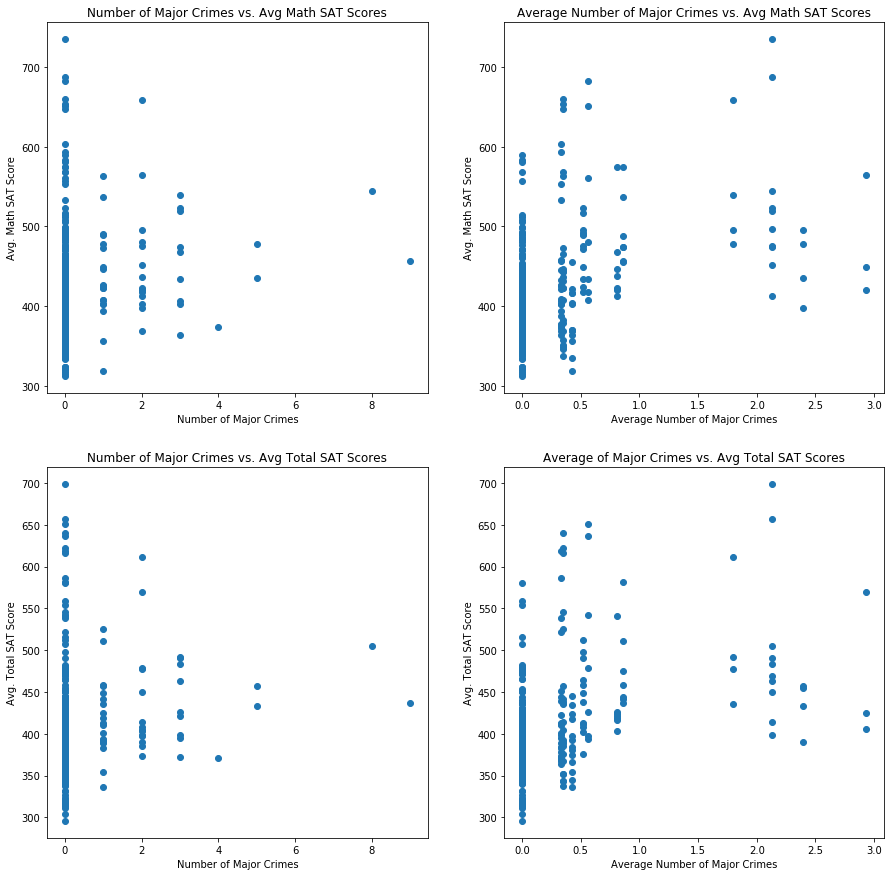

In [33]:
#draw scatter plots

#initalize figure and axis:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(221)

#scatter for Major crimes vs. Math Scores
ax.scatter(schools['Major N'],schools['SAT Math Avg. Score'])
ax.set_title("Number of Major Crimes vs. Avg Math SAT Scores")
ax.set_xlabel("Number of Major Crimes")
ax.set_ylabel("Avg. Math SAT Score")

ax1 = fig.add_subplot(222)
ax1.scatter(schools['AvgOfMajor N'],schools['SAT Math Avg. Score'])
ax1.set_title("Average Number of Major Crimes vs. Avg Math SAT Scores")
ax1.set_xlabel("Average Number of Major Crimes")
ax1.set_ylabel("Avg. Math SAT Score")


ax2 = fig.add_subplot(223)
ax2.scatter(schools['Major N'],schools['total_score'])
ax2.set_title("Number of Major Crimes vs. Avg Total SAT Scores")
ax2.set_xlabel("Number of Major Crimes")
ax2.set_ylabel("Avg. Total SAT Score")


ax3 = fig.add_subplot(224)
ax3.scatter(schools['AvgOfMajor N'],schools['total_score'])
ax3.set_title("Average of Major Crimes vs. Avg Total SAT Scores")
ax3.set_xlabel("Average Number of Major Crimes")
ax3.set_ylabel("Avg. Total SAT Score")



### Figure 3: Scatter Plots of Number of Major Crimes and Average number of major crimes vs. Math SAT scores and Total Average SAT scores. There does seem to be a relationship between major crimes and SAT scores (both math and total), with lower scores at scores where there are major crimes present. For average major crimes the relationship is less clear

In [34]:
#create geometry for lat lon and convert to a geopandas df

geometry = [Point(xy) for xy in zip(schools['Longitude'], schools['Latitude'])]
crs = {'init': 'epsg:4326'}
schools_geo = gpd.GeoDataFrame(schools, crs=crs, geometry=geometry)

In [ ]:
#grab url from PUMA and download the file 
url = 'https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile'

urlretrieve(url, "file.gz")

In [ ]:
#unzip the puma shape files and move them to PUI data
!unzip file.gz -d $PUIDATA #os.system("unzip file.gz -d"+ puidata)

In [36]:
file = 'geo_export_4a4edc4c-a5bf-4caf-8bf0-936ceb65255a.shp'
puma_map = gpd.read_file(os.getenv("PUIDATA")+'/'+file)

In [37]:
#dropping areas where there are no latitude or longitude information so I can visualize it on a map.
schools_geo = schools_geo[schools_geo['Latitude'] != 0]
schools_geo

,School Year,DBN,# Schools,Major N,Oth N,NoCrim N,Prop N,Vio N,ENGroupA,RangeA,...,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,Borough Name,Latitude,Longitude,SAT Math Avg. Score,total_score,geometry
395,2013-14,16K393,3.0,0.0,0.0,0.0,0.0,0.0,2C,1-250,...,0.00,0.00,0.00,0.00,BROOKLYN,40.692126,-73.931731,355.0,356.000000,POINT (-73.931731 40.692126)
405,2013-14,02M418,1.0,0.0,0.0,0.0,0.0,0.0,4C,501-750,...,1.32,1.76,0.83,0.59,MANHATTAN,40.704487,-74.011556,553.0,538.000000,POINT (-74.011556 40.704487)
414,2013-14,16K594,2.0,0.0,0.0,0.0,0.0,0.0,2C,1-250,...,0.00,0.00,0.00,0.00,BROOKLYN,40.680463,-73.922264,372.0,364.333333,POINT (-73.922264 40.680463)
423,2013-14,14K586,3.0,0.0,0.0,0.0,0.0,0.0,4C,501-750,...,0.00,0.00,0.00,0.00,BROOKLYN,40.709941,-73.943641,377.0,367.666667,POINT (-73.943641 40.709941)
424,2013-14,14K454,3.0,0.0,0.0,0.0,0.0,0.0,3C,251-500,...,0.00,0.00,0.00,0.00,BROOKLYN,40.709941,-73.943641,386.0,396.333333,POINT (-73.943641 40.709941)
425,2013-14,14K449,3.0,0.0,0.0,0.0,0.0,0.0,4C,501-750,...,0.00,0.00,0.00,0.00,BROOKLYN,40.709941,-73.943641,584.0,580.000000,POINT (-73.943641 40.709941)
432,2013-14,23K493,2.0,0.0,0.0,0.0,0.0,0.0,3C,251-500,...,0.00,0.00,0.00,0.00,BROOKLYN,40.674103,-73.913273,409.0,395.000000,POINT (-73.913273 40.674103)
438,2013-14,14K071,2.0,0.0,0.0,0.0,0.0,0.0,5C,751-1000,...,0.00,0.00,0.00,0.00,BROOKLYN,40.703624,-73.953146,361.0,361.666667,POINT (-73.95314599999999 40.703624)
491,2013-14,13K412,3.0,0.0,0.0,0.0,0.0,0.0,3C,251-500,...,0.00,0.00,0.00,0.00,BROOKLYN,40.692642,-73.958794,355.0,371.333333,POINT (-73.958794 40.692642)
514,2013-14,15K448,2.0,0.0,0.0,0.0,0.0,0.0,4C,501-750,...,0.00,0.00,0.00,0.00,BROOKLYN,40.680070,-74.001377,399.0,393.000000,POINT (-74.00137700000001 40.68007)


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:389: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "'color'.", UserWarning)


Text(0.5,1,'Map of Locations Schools in NYC')

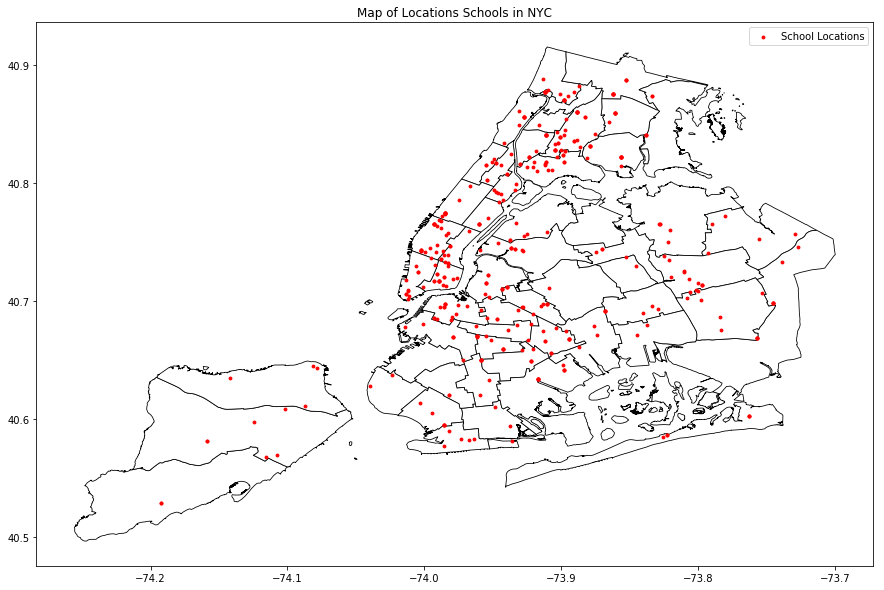

In [92]:
#plot the school locations on a map

fig, ax = plt.subplots(1, figsize=(15, 10))
puma_map.plot(column=None, cmap=None,linewidth=0.8, ax=ax,color='white', k=5, legend=True,edgecolor='black')
schools_geo.plot(column='total_score',color='red',ax=ax, markersize=8,legend=True)
ax.axis('on')
plt.legend(['School Locations'])
plt.title("Map of Locations Schools in NYC")

### Figure 4: Map of school building locations in New York City. 

### Grab hospital discharge data

In [ ]:
#grab a filtered version of the health records data
url3 = 'https://health.data.ny.gov/api/views/u4ud-w55t/rows.csv?accessType=DOWNLOAD'

urlretrieve(url3, "discharge.csv") #import from url

In [ ]:
#move to puidata
!mv discharge.csv $PUIDATA

In [39]:
#import discharge data with pandas
discharge = pd.read_csv(os.getenv("PUIDATA")+'/'+'discharge.csv')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [40]:
discharge.head()

,Health Service Area,Hospital County,Operating Certificate Number,Facility ID,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,...,Payment Typology 2,Payment Typology 3,Attending Provider License Number,Operating Provider License Number,Other Provider License Number,Birth Weight,Abortion Edit Indicator,Emergency Department Indicator,Total Charges,Total Costs
0,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,30 to 49,147,F,White,Not Span/Hispanic,...,NaN,NaN,90301264.0,NaN,NaN,0,N,Y,5511.95,5582.49
1,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,70 or Older,147,F,White,Not Span/Hispanic,...,NaN,NaN,90301264.0,NaN,NaN,0,N,Y,4783.20,5162.82
2,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,30 to 49,147,F,White,Not Span/Hispanic,...,NaN,NaN,90301264.0,NaN,NaN,0,N,Y,3829.15,4056.52
3,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,0 to 17,147,F,White,Not Span/Hispanic,...,NaN,NaN,182357.0,NaN,NaN,0,N,Y,1108.20,1644.75
4,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,70 or Older,147,F,White,Not Span/Hispanic,...,NaN,NaN,90301264.0,NaN,NaN,0,N,Y,3418.18,3370.87


In [41]:
#throw away non-new york city data
discharge = discharge[discharge['Health Service Area'] == 'New York City']
discharge.head()

,Health Service Area,Hospital County,Operating Certificate Number,Facility ID,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,...,Payment Typology 2,Payment Typology 3,Attending Provider License Number,Operating Provider License Number,Other Provider License Number,Birth Weight,Abortion Edit Indicator,Emergency Department Indicator,Total Charges,Total Costs
954417,New York City,Bronx,7000002.0,1165.0,Jacobi Medical Center,0 to 17,104,F,Black/African American,Not Span/Hispanic,...,Medicaid,NaN,197201.0,NaN,NaN,0,N,Y,10408.87,8618.38
954464,New York City,Bronx,7000002.0,1165.0,Jacobi Medical Center,50 to 69,104,M,Black/African American,Not Span/Hispanic,...,NaN,NaN,186946.0,NaN,NaN,0,N,Y,4652.69,3852.35
954762,New York City,Bronx,7000002.0,1165.0,Jacobi Medical Center,30 to 49,104,F,Other Race,Spanish/Hispanic,...,Medicaid,NaN,3872.0,NaN,NaN,0,N,Y,4044.20,3348.53
954951,New York City,Bronx,7000002.0,1165.0,Jacobi Medical Center,0 to 17,104,M,Other Race,Spanish/Hispanic,...,Medicaid,NaN,261112.0,NaN,NaN,0,N,Y,9130.51,7559.92
954967,New York City,Bronx,7000002.0,1165.0,Jacobi Medical Center,50 to 69,104,F,White,Not Span/Hispanic,...,NaN,NaN,253123.0,NaN,NaN,0,N,Y,4171.46,3453.90


In [42]:
discharge.shape #dataframe is about 40% of original

(1199520, 37)

In [43]:
print("the number of nyc discharges {}".format(discharge['Facility ID'].count()))

the number of nyc discharges 1199520


In [44]:
discharge.columns

Index(['Health Service Area', 'Hospital County',
       'Operating Certificate Number', 'Facility ID', 'Facility Name',
       'Age Group', 'Zip Code - 3 digits', 'Gender', 'Race', 'Ethnicity',
       'Length of Stay', 'Type of Admission', 'Patient Disposition',
       'Discharge Year', 'CCS Diagnosis Code', 'CCS Diagnosis Description',
       'CCS Procedure Code', 'CCS Procedure Description', 'APR DRG Code',
       'APR DRG Description', 'APR MDC Code', 'APR MDC Description',
       'APR Severity of Illness Code', 'APR Severity of Illness Description',
       'APR Risk of Mortality', 'APR Medical Surgical Description',
       'Payment Typology 1', 'Payment Typology 2', 'Payment Typology 3',
       'Attending Provider License Number',
       'Operating Provider License Number', 'Other Provider License Number',
       'Birth Weight', 'Abortion Edit Indicator',
       'Emergency Department Indicator', 'Total Charges', 'Total Costs'],
      dtype='object')

In [45]:
#list the diagnosis descriptions
discharge['CCS Diagnosis Description'].unique()

array(['Asthma', 'Nonspecific chest pain', 'Epilepsy; convulsions',
       'Burns', 'Syncope', 'Schizophrenia and other psychotic disorders',
       'Mood disorders',
       'Attention-deficit, conduct, and disruptive behavior disorders',
       'Alcohol-related disorders', 'Adjustment disorders',
       'Substance-related disorders', 'Miscellaneous disorders',
       'Delirium, dementia, and amnestic and other cognitive disorders',
       'Impulse control disorders, NEC', 'Anxiety disorders',
       'Suicide and intentional self-inflicted injury',
       'Other complications of pregnancy', 'Personality disorders',
       'Rehabilitation care; fitting of prostheses; and adjustment of devices',
       'Disorders usually diagnosed in infancy, childhood, or adolescence',
       'Residual codes; unclassified', 'Nausea and vomiting',
       'Poisoning by other medications and drugs',
       'Poisoning by psychotropic agents', 'Prolonged pregnancy',
       'HIV infection', 'Acute and unspeci

In [46]:
#make a list of relevant disorders for filtering dataframe
asthma_list = ['Asthma','Respiratory failure; insufficiency; arrest (adult)','Respiratory distress syndrome']
drug_list = ['Alcohol-related disorders','Substance-related disorders']

In [47]:
print("The number of facilities in NYC is {}".format(discharge['Facility ID'].nunique()))

The number of facilities in NYC is 61


In [48]:
#make a df of just the asthma related diagnoses
asthma_frame = discharge[discharge['CCS Diagnosis Description'].isin(asthma_list)] 
#print the number of asthma related illnesses
print("number of asthma related cases in NYC {}".format(asthma_frame['Facility ID'].count()))

number of asthma related cases in NYC 30717


In [49]:
#make a df of just the drug related diagnoses
drug_frame = discharge[discharge['CCS Diagnosis Description'].isin(drug_list)] 
#print the number of drug related illnesses
print("number of drug related cases in NYC {}".format(drug_frame['Facility ID'].count()))

number of drug related cases in NYC 44678


In [50]:
#group the asthma dataframe by the number of cases
asthma_frame = asthma_frame.groupby('Facility ID')['Operating Certificate Number'].count()
asthma_frame = pd.DataFrame(asthma_frame)
asthma_frame.head()

,Operating Certificate Number
Facility ID,
1165.0,1123
1168.0,580
1169.0,2105
1172.0,1826
1175.0,25


In [51]:
#group the drug df by number of cases
drug_frame = drug_frame.groupby('Facility ID')['Operating Certificate Number'].count()
drug_frame = pd.DataFrame(drug_frame)
drug_frame.head()

,Operating Certificate Number
Facility ID,
1164.0,2388
1165.0,1228
1168.0,990
1169.0,280
1172.0,548


In [52]:
#join asthma and drug summary tables
drug_asthma = pd.merge(left=asthma_frame,right=drug_frame,how='outer',left_index=True,right_index=True)
drug_asthma.head()

,Operating Certificate Number_x,Operating Certificate Number_y
Facility ID,,
1164.0,NaN,2388.0
1165.0,1123.0,1228.0
1168.0,580.0,990.0
1169.0,2105.0,280.0
1172.0,1826.0,548.0


In [53]:
#rename columns 
drug_asthma.rename(columns={'Operating Certificate Number_x':'asthma','Operating Certificate Number_y':'drugs'},
                   inplace=True)
drug_asthma.columns #check they were renamed

Index(['asthma', 'drugs'], dtype='object')

In [54]:
#aggregate initial discharge table to get total discharges by facility id
total_discharge = discharge.groupby('Facility ID')['Operating Certificate Number'].count()
total_discharge = pd.DataFrame(total_discharge)

In [55]:
#merge aggregated discharges with asthma and drug count table
drug_asthma_rat = pd.merge(left=total_discharge,right=drug_asthma,how='outer',left_index=True,right_index=True)
drug_asthma_rat.head()

,Operating Certificate Number,asthma,drugs
Facility ID,,,
1164.0,4917,NaN,2388.0
1165.0,20956,1123.0,1228.0
1168.0,15889,580.0,990.0
1169.0,43650,2105.0,280.0
1172.0,23142,1826.0,548.0


In [56]:
#rename column
drug_asthma_rat.rename(columns={'Operating Certificate Number':'total'},
                   inplace=True)

In [57]:
#calculate ratios
drug_asthma_rat['asthma_rat'] = drug_asthma_rat['asthma'] / drug_asthma_rat['total']
drug_asthma_rat['drug_rat'] = drug_asthma_rat['drugs'] / drug_asthma_rat['total']

In [58]:
#fill nan columns
drug_asthma_rat.fillna(value=0,inplace=True)

In [59]:
drug_asthma_rat.head()

,total,asthma,drugs,asthma_rat,drug_rat
Facility ID,,,,,
1164.0,4917,0.0,2388.0,0.000000,0.485662
1165.0,20956,1123.0,1228.0,0.053588,0.058599
1168.0,15889,580.0,990.0,0.036503,0.062307
1169.0,43650,2105.0,280.0,0.048225,0.006415
1172.0,23142,1826.0,548.0,0.078904,0.023680


In [60]:
drug_asthma_rat.shape

(61, 5)

### Grab facility locations from Carto

In [61]:
#set up query and script using queryCarto() function provided by professor

my_query = 'SELECT * FROM fb55.nyc_facilities'
my_source = 'https://fb55.carto.com:443/api/v2/sql?q='

facility_locs = get_data(my_query,my_source)
facility_locs.head()

,the_geom,regional_office,the_geom_webmercator,facility_id,facility_name,short_description,description,facility_open_date,facility_address_1,facility_address_2,...,cooperator_name,cooperator_address,cooperator_address_2,cooperator_city,cooperator_state,cooperator_zip_code,ownership_type,facility_latitude,facility_longitude,facility_location
0,0101000020E6100000E40F069E7B7C52C05952EE3EC753...,Metropolitan Area Regional Office - New York City,0101000020110F000046B5633099665FC167AF70FB3AED...,1320,University Hospital of Brooklyn,HOSP,Hospital,01/01/1901,445 Lenox Road,NaN,...,NaN,NaN,NaN,NaN,New York,NaN,State,40.654518,-73.945045,"(40.654518, -73.945045)"
1,0101000020E61000008BC058DFC07852C04BC8073D9B53...,Metropolitan Area Regional Office - New York City,0101000020110F00001F2C777543605FC14E668BB709ED...,6448,PALA Community Care,DTC,Diagnostic and Treatment Center,09/12/2002,1110 Pennsylvania Avenue,NaN,...,NaN,NaN,NaN,NaN,New York,NaN,LLC,40.653175,-73.886772,"(40.653175, -73.886772)"
2,0101000020E6100000D3DC0A61357D52C09AFF571D3958...,Metropolitan Area Regional Office - New York City,0101000020110F00006ACD5FB9D4675FC19AEE7C2435F2...,6754,Medcare LLC,DTC,Diagnostic and Treatment Center,02/26/2007,468 Lafayette Avenue,NaN,...,NaN,NaN,NaN,NaN,New York,NaN,LLC,40.689243,-73.956383,"(40.689243, -73.956383)"
3,0101000020E61000006DCA15DEE57952C08A027D224F6C...,Metropolitan Area Regional Office - New York City,0101000020110F00007164F52335625FC110A7A85CBB08...,1206,P R O M E S A Inc,DTC,Diagnostic and Treatment Center,09/27/1979,1776 Clay Avenue,NaN,...,NaN,NaN,NaN,NaN,New York,NaN,Not for Profit Corporation,40.846165,-73.904655,"(40.846165, -73.904655)"
4,0101000020E6100000D6C4025FD17A52C038BF61A24168...,Metropolitan Area Regional Office - New York City,0101000020110F00006301C42AC5635FC1A351F0D12E04...,1207,Narco Freedom Inc,DTC,Diagnostic and Treatment Center,09/27/1979,479 Willis Avenue,NaN,...,NaN,NaN,NaN,NaN,New York,NaN,Not for Profit Corporation,40.814503,-73.919029,"(40.814503, -73.919029)"


In [62]:
#filter facility locs so we just have what we need, id and location
facility_locs = facility_locs[['facility_id','facility_latitude','facility_longitude','facility_location']]

In [63]:
#set index of facility locs
facility_locs.set_index('facility_id',inplace=True)

In [64]:
#merge dataframes
da_rat_loc = pd.merge(left=drug_asthma_rat,right=facility_locs,how='left',left_index=True,right_index=True)
da_rat_loc

,total,asthma,drugs,asthma_rat,drug_rat,facility_latitude,facility_longitude,facility_location
1164.0,4917,0.0,2388.0,0.000000,0.485662,40.831772,-73.903656,"(40.831772, -73.903656)"
1165.0,20956,1123.0,1228.0,0.053588,0.058599,40.857388,-73.846741,"(40.857388, -73.846741)"
1168.0,15889,580.0,990.0,0.036503,0.062307,40.894569,-73.861420,"(40.894569, -73.86142)"
1169.0,43650,2105.0,280.0,0.048225,0.006415,40.879951,-73.880562,"(40.879951, -73.880562)"
1172.0,23142,1826.0,548.0,0.078904,0.023680,40.817661,-73.924210,"(40.817661, -73.92421)"
1175.0,3043,25.0,0.0,0.008216,0.000000,40.847294,-73.844658,"(40.847294, -73.844658)"
1176.0,20585,910.0,4147.0,0.044207,0.201457,40.853909,-73.891014,"(40.853909, -73.891014)"
1178.0,24810,1351.0,284.0,0.054454,0.011447,40.843609,-73.911545,"(40.843609, -73.911545)"
1185.0,4631,264.0,15.0,0.057007,0.003239,40.840431,-73.848244,"(40.840431, -73.848244)"
1186.0,8767,248.0,160.0,0.028288,0.018250,40.880512,-73.881538,"(40.880512, -73.881538)"


In [65]:
#dropping where we don't have location
da_rat_loc.dropna(subset=['facility_latitude'],inplace=True)
print("the number of facilities left after the merge is {} implying 4 were lost".format(da_rat_loc['total'].count()))

the number of facilities left after the merge is 57 implying 4 were lost


### Aggregate to PUMA geography for mapping

In [66]:
#create geometry for lat lon and convert to a geopandas df for hospital data

geometry = [Point(xy) for xy in zip(da_rat_loc['facility_longitude'], da_rat_loc['facility_latitude'])]
crs = {'init': 'epsg:4326'}
facility_geo = gpd.GeoDataFrame(da_rat_loc, crs=crs, geometry=geometry)

Text(0.5,1,'Map of School and Hospital Locations in NYC')

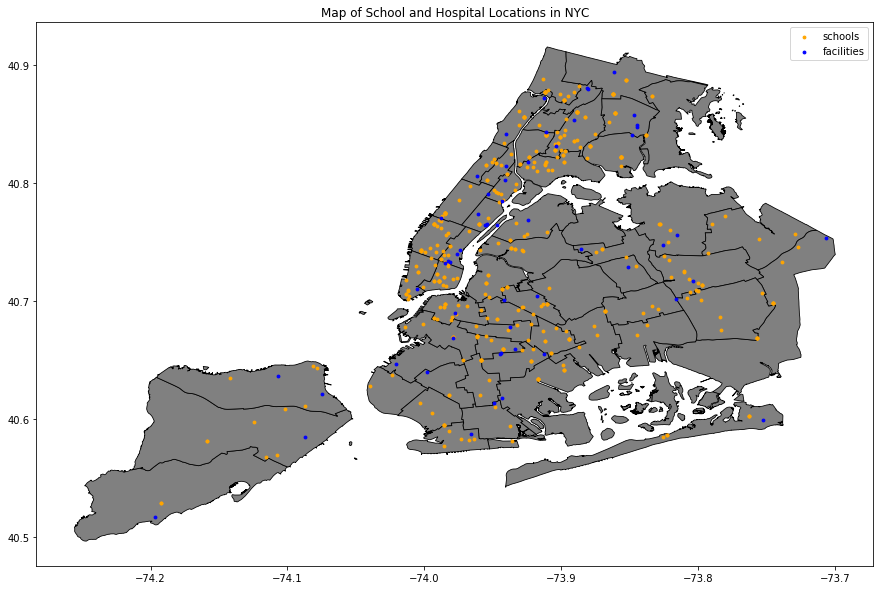

In [67]:
#plot schools and hospitals on the map
fig, ax = plt.subplots(1, figsize=(15, 10))

puma_map.plot(column=None, cmap=None,linewidth=0.8, ax=ax,color='grey',edgecolor='black')

schools_geo.plot(column=None,color='orange',ax=ax, markersize=8)

facility_geo.plot(column=None,color='blue',ax=ax, markersize=8)

ax.axis('on')
plt.legend(['schools','facilities'])
plt.title("Map of School and Hospital Locations in NYC")

### Figure 5: Shows school locations in orange and hospitals in blue for New York City. 

### Join data sources

In [68]:
#spatial join the puma data with the facilities data
puma_facilities = gpd.sjoin(puma_map,facility_geo,how='right',op='intersects')
puma_facilities.head()

,index_left,puma,shape_area,shape_leng,total,asthma,drugs,asthma_rat,drug_rat,facility_latitude,facility_longitude,facility_location,geometry
index_right,,,,,,,,,,,,,
1168.0,1,3702,1.889860e+08,106050.002302,15889,580.0,990.0,0.036503,0.062307,40.894569,-73.861420,"(40.894569, -73.86142)",POINT (-73.86142 40.894569)
1165.0,3,3704,1.062129e+08,47970.901277,20956,1123.0,1228.0,0.053588,0.058599,40.857388,-73.846741,"(40.857388, -73.846741)",POINT (-73.84674100000001 40.857388)
3058.0,3,3704,1.062129e+08,47970.901277,27100,556.0,80.0,0.020517,0.002952,40.849575,-73.845055,"(40.849575, -73.845055)",POINT (-73.845055 40.849575)
1175.0,3,3704,1.062129e+08,47970.901277,3043,25.0,0.0,0.008216,0.000000,40.847294,-73.844658,"(40.847294, -73.844658)",POINT (-73.844658 40.847294)
1293.0,5,4016,1.207135e+08,109477.751817,7568,225.0,48.0,0.029730,0.006342,40.613419,-73.948967,"(40.613419, -73.948967)",POINT (-73.94896700000001 40.613419)


In [69]:
#roll up to the puma level, first sum the columsn, then calculate the ratios so it's a weighted average
puma_facilities = puma_facilities.groupby('puma')[['total','asthma','drugs']].sum()
puma_facilities.head()

,total,asthma,drugs
puma,,,
3702,15889,580.0,990.0
3704,51099,1704.0,1308.0
3705,25502,910.0,6535.0
3706,52417,2353.0,440.0
3707,24810,1351.0,284.0


In [70]:
#calculate puma level ratios for asthma and drug discharges
puma_facilities['asthma_rat'] = puma_facilities['asthma'] / puma_facilities['total']
puma_facilities['drug_rat'] = puma_facilities['drugs'] / puma_facilities['total']
puma_facilities.head()

,total,asthma,drugs,asthma_rat,drug_rat
puma,,,,,
3702,15889,580.0,990.0,0.036503,0.062307
3704,51099,1704.0,1308.0,0.033347,0.025597
3705,25502,910.0,6535.0,0.035683,0.256254
3706,52417,2353.0,440.0,0.044890,0.008394
3707,24810,1351.0,284.0,0.054454,0.011447


In [71]:
#spatially join the puma polygons with the schools data
puma_schools = gpd.sjoin(puma_map,schools_geo,how='right',op='intersects')
puma_schools.head()

,index_left,puma,shape_area,shape_leng,School Year,DBN,# Schools,Major N,Oth N,NoCrim N,...,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,Borough Name,Latitude,Longitude,SAT Math Avg. Score,total_score,geometry
index_right,,,,,,,,,,,,,,,,,,,,,
2047,0,3701,9.792852e+07,53227.144461,2013-14,10X549,6.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,BRONX,40.870293,-73.898309,379.0,371.666667,POINT (-73.898309 40.870293)
2064,0,3701,9.792852e+07,53227.144461,2013-14,10X268,6.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,BRONX,40.870293,-73.898309,356.0,320.666667,POINT (-73.898309 40.870293)
2065,0,3701,9.792852e+07,53227.144461,2013-14,10X342,6.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,BRONX,40.870293,-73.898309,333.0,311.333333,POINT (-73.898309 40.870293)
2066,0,3701,9.792852e+07,53227.144461,2013-14,10X433,6.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,BRONX,40.870293,-73.898309,371.0,368.666667,POINT (-73.898309 40.870293)
2067,0,3701,9.792852e+07,53227.144461,2013-14,10X442,6.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,BRONX,40.870293,-73.898309,420.0,423.333333,POINT (-73.898309 40.870293)


In [72]:
puma_schools.columns

Index(['index_left', 'puma', 'shape_area', 'shape_leng', 'School Year', 'DBN',
       '# Schools', 'Major N', 'Oth N', 'NoCrim N', 'Prop N', 'Vio N',
       'ENGroupA', 'RangeA', 'AvgOfMajor N', 'AvgOfOth N', 'AvgOfNoCrim N',
       'AvgOfProp N', 'AvgOfVio N', 'Borough Name', 'Latitude', 'Longitude',
       'SAT Math Avg. Score', 'total_score', 'geometry'],
      dtype='object')

In [73]:
puma_schools = puma_schools.groupby('puma')[['Major N', 'Oth N', 'NoCrim N', 'Prop N', 'Vio N',
                                              'AvgOfMajor N','AvgOfOth N', 'AvgOfNoCrim N',
                                              'AvgOfProp N', 'AvgOfVio N',
                                             'SAT Math Avg. Score','total_score']].mean()
puma_schools.head()

,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,SAT Math Avg. Score,total_score
puma,,,,,,,,,,,,
3701,0.090909,0.454545,1.363636,0.272727,0.181818,0.354545,1.434545,2.245455,0.938182,0.581818,443.363636,430.363636
3702,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,378.555556,374.740741
3703,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,394.400000,391.400000
3704,0.000000,1.166667,0.833333,0.333333,0.666667,0.055000,0.220000,0.293333,0.138333,0.098333,412.666667,404.611111
3705,0.185185,1.111111,1.296296,0.296296,0.592593,0.061852,0.234815,0.301111,0.150000,0.105926,378.222222,373.629630


In [74]:
#last join to add health data

puma_all = pd.merge(puma_schools,puma_facilities,how='outer',left_index=True,right_index=True)
puma_all.head()

,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,SAT Math Avg. Score,total_score,total,asthma,drugs,asthma_rat,drug_rat
puma,,,,,,,,,,,,,,,,,
3701,0.090909,0.454545,1.363636,0.272727,0.181818,0.354545,1.434545,2.245455,0.938182,0.581818,443.363636,430.363636,NaN,NaN,NaN,NaN,NaN
3702,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,378.555556,374.740741,15889.0,580.0,990.0,0.036503,0.062307
3703,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,394.400000,391.400000,NaN,NaN,NaN,NaN,NaN
3704,0.000000,1.166667,0.833333,0.333333,0.666667,0.055000,0.220000,0.293333,0.138333,0.098333,412.666667,404.611111,51099.0,1704.0,1308.0,0.033347,0.025597
3705,0.185185,1.111111,1.296296,0.296296,0.592593,0.061852,0.234815,0.301111,0.150000,0.105926,378.222222,373.629630,25502.0,910.0,6535.0,0.035683,0.256254


In [101]:
puma_all.shape

(38, 19)

### Grab income data from ACS https://factfinder.census.gov/faces/nav/jsf/pages/download_center.xhtml

In [75]:
#grab ACS data hosted on a github repo I initialized
url = 'https://raw.githubusercontent.com/cb4102/affdata/master/ACS_12_5YR_S1901_with_ann.csv'

income_data = pd.read_csv(url,skiprows=1)
income_data.columns

Index(['Id', 'Id2', 'Geography', 'Households; Estimate; Total',
       'Households; Margin of Error; Total', 'Families; Estimate; Total',
       'Families; Margin of Error; Total',
       'Married-couple families; Estimate; Total',
       'Married-couple families; Margin of Error; Total',
       'Nonfamily households; Estimate; Total',
       ...
       'Nonfamily households; Estimate; PERCENT IMPUTED - Family income in the past 12 months',
       'Nonfamily households; Margin of Error; PERCENT IMPUTED - Family income in the past 12 months',
       'Households; Estimate; PERCENT IMPUTED - Nonfamily income in the past 12 months',
       'Households; Margin of Error; PERCENT IMPUTED - Nonfamily income in the past 12 months',
       'Families; Estimate; PERCENT IMPUTED - Nonfamily income in the past 12 months',
       'Families; Margin of Error; PERCENT IMPUTED - Nonfamily income in the past 12 months',
       'Married-couple families; Estimate; PERCENT IMPUTED - Nonfamily income in the p

In [76]:
#filter to columns I need
income_data = income_data[['Id2','Households; Estimate; Total']]
income_data.head()

,Id2,Households; Estimate; Total
0,3600100,42076
1,3600200,69322
2,3600300,53105
3,3600401,47090
4,3600402,63664


In [77]:
income_data['Id3'] = income_data['Id2'].astype(str) #set as a string so I can splice the id column more easily

In [78]:
income_data['Id3'] = income_data['Id3'].str[-4:] #splice string we get last four digits of id

In [79]:
puma_all.reset_index(inplace=True) #reset index so I can join on the puma column

In [80]:
#perform merge
puma_all = pd.merge(left=puma_all,right=income_data,how='left',left_on='puma',right_on='Id3')
puma_all.head()

,puma,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,...,SAT Math Avg. Score,total_score,total,asthma,drugs,asthma_rat,drug_rat,Id2,Households; Estimate; Total,Id3
0,3701,0.090909,0.454545,1.363636,0.272727,0.181818,0.354545,1.434545,2.245455,0.938182,...,443.363636,430.363636,NaN,NaN,NaN,NaN,NaN,3603701,40997,3701
1,3702,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,378.555556,374.740741,15889.0,580.0,990.0,0.036503,0.062307,3603702,47061,3702
2,3703,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,394.400000,391.400000,NaN,NaN,NaN,NaN,NaN,3603703,46181,3703
3,3704,0.000000,1.166667,0.833333,0.333333,0.666667,0.055000,0.220000,0.293333,0.138333,...,412.666667,404.611111,51099.0,1704.0,1308.0,0.033347,0.025597,3603704,44207,3704
4,3705,0.185185,1.111111,1.296296,0.296296,0.592593,0.061852,0.234815,0.301111,0.150000,...,378.222222,373.629630,25502.0,910.0,6535.0,0.035683,0.256254,3603705,52247,3705


In [81]:
#drop columns we won't need
puma_all.drop(['Id2','Id3'],inplace=True,axis=1)
puma_all.head()

,puma,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,SAT Math Avg. Score,total_score,total,asthma,drugs,asthma_rat,drug_rat,Households; Estimate; Total
0,3701,0.090909,0.454545,1.363636,0.272727,0.181818,0.354545,1.434545,2.245455,0.938182,0.581818,443.363636,430.363636,NaN,NaN,NaN,NaN,NaN,40997
1,3702,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,378.555556,374.740741,15889.0,580.0,990.0,0.036503,0.062307,47061
2,3703,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,394.400000,391.400000,NaN,NaN,NaN,NaN,NaN,46181
3,3704,0.000000,1.166667,0.833333,0.333333,0.666667,0.055000,0.220000,0.293333,0.138333,0.098333,412.666667,404.611111,51099.0,1704.0,1308.0,0.033347,0.025597,44207
4,3705,0.185185,1.111111,1.296296,0.296296,0.592593,0.061852,0.234815,0.301111,0.150000,0.105926,378.222222,373.629630,25502.0,910.0,6535.0,0.035683,0.256254,52247


### Basic visualization to find some relationships

Text(0.02,0.02,'the correlation between math sat scores and total sat scores 0.9445194700265621')

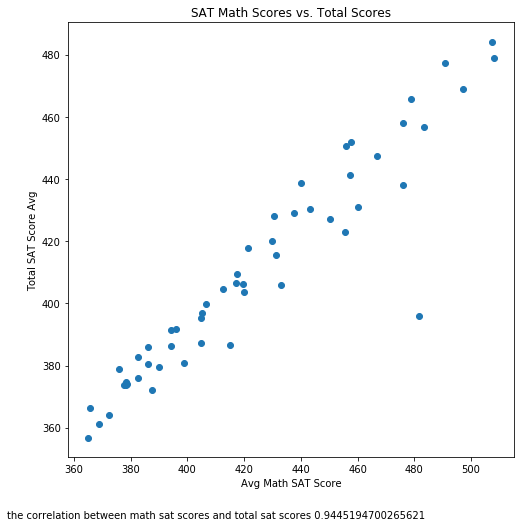

In [82]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

#scatter for Major crimes vs. Math Scores
ax.scatter(puma_all['SAT Math Avg. Score'],puma_all['total_score'])
ax.set_title("SAT Math Scores vs. Total Scores")
ax.set_xlabel("Avg Math SAT Score")
ax.set_ylabel("Total SAT Score Avg")
plt.figtext(.02, .02, "the correlation between math sat scores and total sat scores {}".format(
    puma_all['SAT Math Avg. Score'].corr(puma_all['total_score'])), rotation='horizontal')

#### Figure 6: Scatter plot between Average SAT math scores and average total SAT scores by PUMA.  checking for collinearity in the SAT scores

Text(0,0.5,'Avg. non=crime Crime')

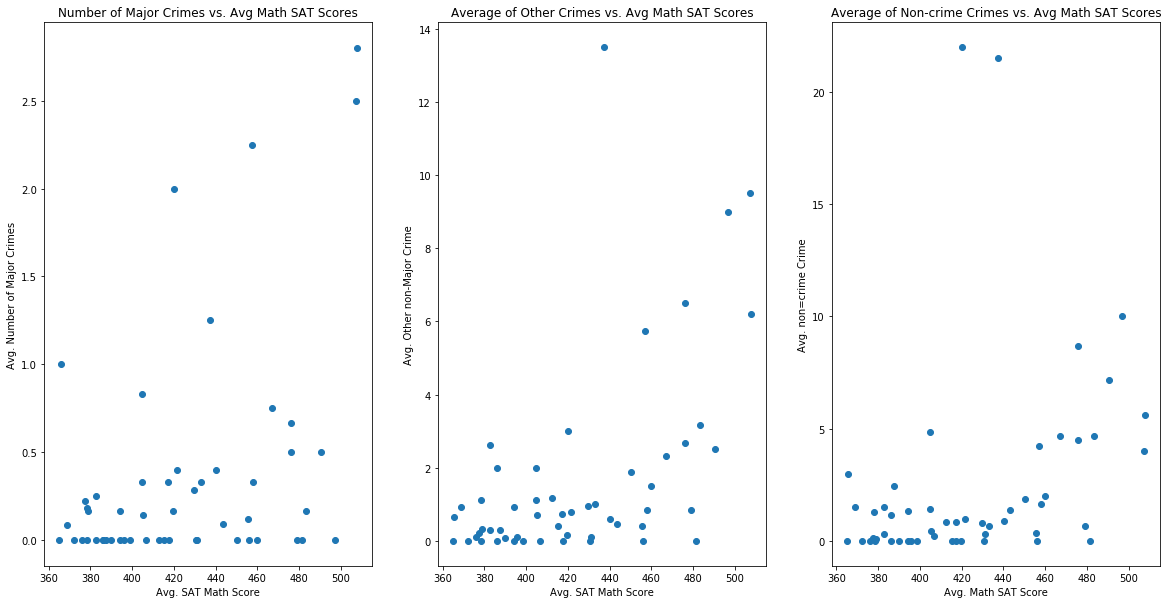

In [83]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(131)

#scatter for Major crimes vs. Math Scores
ax.scatter(puma_all['SAT Math Avg. Score'],puma_all['Major N'])
ax.set_title("Number of Major Crimes vs. Avg Math SAT Scores")
ax.set_xlabel("Avg. SAT Math Score")
ax.set_ylabel("Avg. Number of Major Crimes")

ax1 = fig.add_subplot(132)
ax1.scatter(puma_all['SAT Math Avg. Score'],puma_all['Oth N'])
ax1.set_title("Average of Other Crimes vs. Avg Math SAT Scores")
ax1.set_xlabel("Avg. SAT Math Score")
ax1.set_ylabel("Avg. Other non-Major Crime")


ax2 = fig.add_subplot(133)
ax2.scatter(puma_all['SAT Math Avg. Score'],puma_all['NoCrim N'])
ax2.set_title("Average of Non-crime Crimes vs. Avg Math SAT Scores")
ax2.set_xlabel("Avg. Math SAT Score")
ax2.set_ylabel("Avg. non=crime Crime")

### Figure 7: Three scatter plots comparing Avg. SAT Math Scores to three crime statistics - average total major crimes, average of non-major crimes, and average of non-crime crimes. There are many values near or at zero for crime values across the range of SAT scores. Surprisingly, there seems to be a mild positive correlation between SAT scores and crime at the PUMA level. Though it's certainly a weak effect, some of these outliers could be explained by having either one very unsafe school in a PUMA that scews the crime statistics upward, or visa versa with the SAT score data. In lower income neighborhoods, where you might expect higher levels of school crime, there could be charter schools with exceptional SAT scores that skew those SAT values. In addition, certain major crimes may be completed uncorrelated with school performance and given that the volume is so low, it would only take one event to skew a PUMA's average, for example, there were a number of sexual assualt charges at an all-boys private school in Toronto recently despite the fact that the school produces academically successful graduates

In [84]:
#dropping the NaN values 

puma_all.dropna(subset=['asthma_rat'],inplace=True)

Text(0,0.5,'Avg. Ratio of Drug Related Hospitalizations')

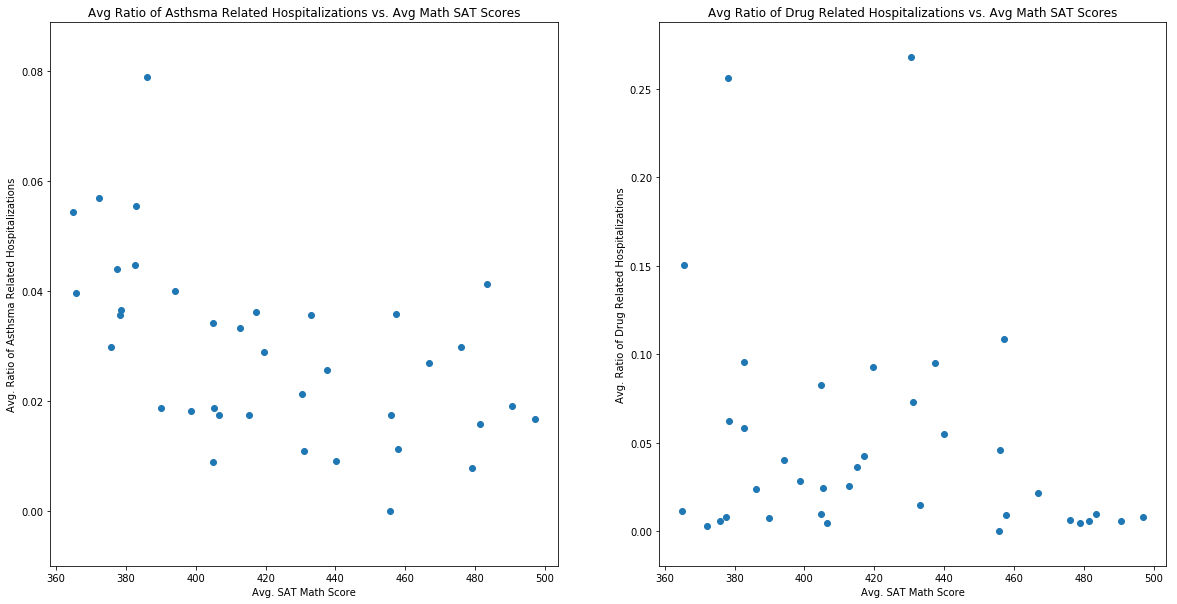

In [85]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(121)

#scatter for Major crimes vs. Math Scores
ax.scatter(puma_all['SAT Math Avg. Score'],puma_all['asthma_rat'])
ax.set_title("Avg Ratio of Asthsma Related Hospitalizations vs. Avg Math SAT Scores")
ax.set_xlabel("Avg. SAT Math Score")
ax.set_ylabel("Avg. Ratio of Asthsma Related Hospitalizations")

ax1 = fig.add_subplot(122)
ax1.scatter(puma_all['SAT Math Avg. Score'],puma_all['drug_rat'])
ax1.set_title("Avg Ratio of Drug Related Hospitalizations vs. Avg Math SAT Scores")
ax1.set_xlabel("Avg. SAT Math Score")
ax1.set_ylabel("Avg. Ratio of Drug Related Hospitalizations")

### Figure 8: Shows scatter plots of the ratio of hospitalizations for asthma and drug-related reasons within a PUMA  with Avg Math SAT Scores. For asthma ratio we see a negative correlation. Since asthma impacts children more than adults, this relationship makes sense. There could be more hospitalizations in areas that have more pollution and don't have ready access to medical services, and this could impact children's performance in school and could be a proxy for lower quality public health in general. We don't see as strong of a negative correlation for drug-related hospitalization, though there are still PUMA areas where we see high hospitalization ratios along with low math SAT scores

Text(0,0.5,'Avg. Household Income')

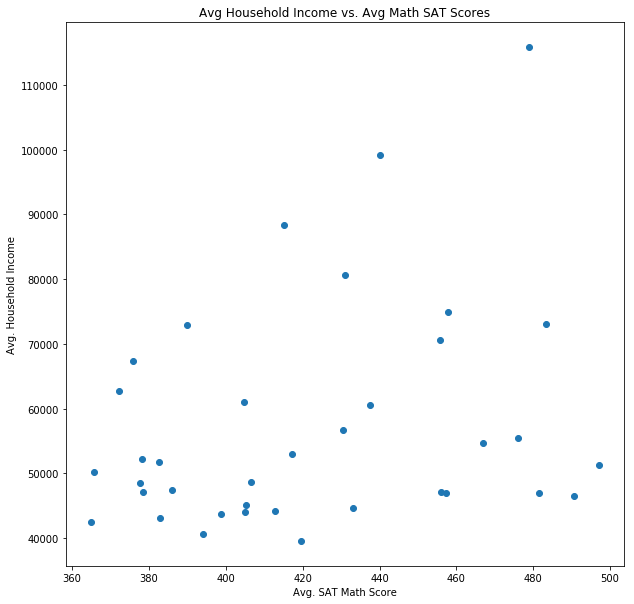

In [86]:
#initialize income vs. sat graph
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

ax.scatter(puma_all['SAT Math Avg. Score'],puma_all['Households; Estimate; Total'])
ax.set_title("Avg Household Income vs. Avg Math SAT Scores")
ax.set_xlabel("Avg. SAT Math Score")
ax.set_ylabel("Avg. Household Income")

### Figure 9: Avg. Math SAT Score vs. Avg. Household Income shows a positive  correlation, though not particularly strong. It would make sense for there to be a positive relationship between inome and SAT score as wealthy people can afford to live in neighborhoods with good schools, and the children who go to those schools are more likely to have educated parents at home which has been shown to be a predictor of success in school

In [87]:
#make covariance matrix

school_corr = puma_all.corr()

In [88]:
#make a list of features from the columns in the dataframe
feature_list = puma_all.columns

Text(0.5,1,'Covariance Matrix of School and Crime Features by PUMA')

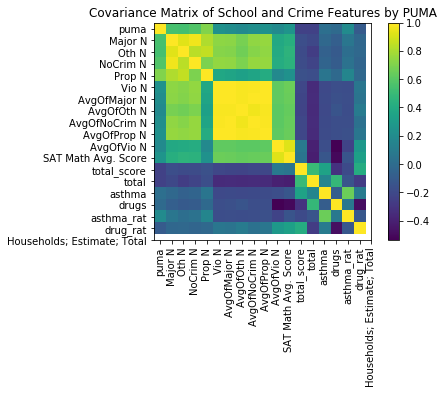

In [90]:
#plot covariance matrix

#initalize axis 
ax = plt.figure().add_subplot(111)
cax = ax.imshow(school_corr) #print color grid
plt.colorbar(cax) #show colorbar

ax.set_xticks(range(len(feature_list)))
ax.set_xticklabels(feature_list, rotation=90)
ax.set_yticks(range(len(feature_list)))
ax.set_yticklabels(feature_list)
ax.set_title("Covariance Matrix of School and Crime Features by PUMA")

### Mapping

In [100]:
#join puma_all back to geopandas dataframe
puma_geo = pd.merge(puma_map,puma_all,how='left',left_on='puma',right_on='puma') 
puma_geo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 55 entries, 0 to 54
Data columns (total 22 columns):
puma                           55 non-null object
shape_area                     55 non-null float64
shape_leng                     55 non-null float64
geometry                       55 non-null object
Major N                        37 non-null float64
Oth N                          37 non-null float64
NoCrim N                       37 non-null float64
Prop N                         37 non-null float64
Vio N                          37 non-null float64
AvgOfMajor N                   37 non-null float64
AvgOfOth N                     37 non-null float64
AvgOfNoCrim N                  37 non-null float64
AvgOfProp N                    37 non-null float64
AvgOfVio N                     37 non-null float64
SAT Math Avg. Score            37 non-null float64
total_score                    37 non-null float64
total                          38 non-null float64
asthma                  

Text(0.5,1,'Heat Map of Avg. Total SAT Scores by PUMA in NYC, 2012')

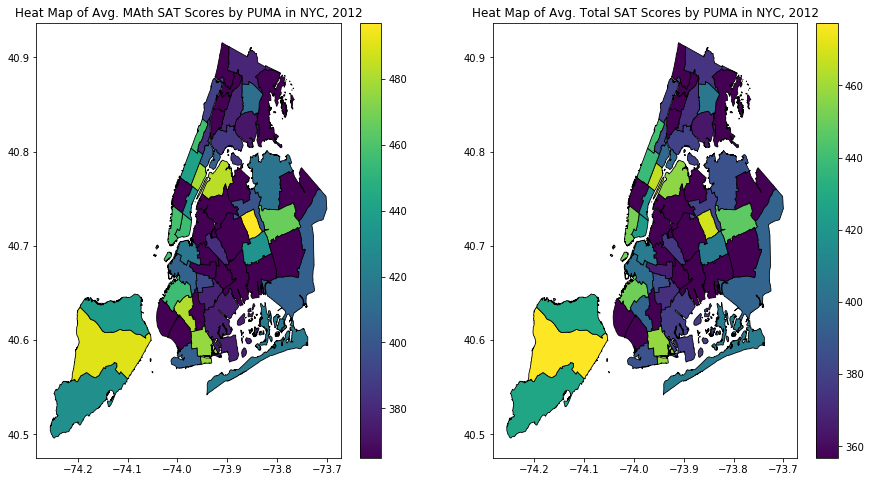

In [123]:
#plot SAT scores on a heat map
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(121)

puma_geo.plot(column='SAT Math Avg. Score', cmap='viridis',linewidth=0.8, ax=ax,edgecolor='black',legend=True)

ax.axis('on')
ax.set_title("Heat Map of Avg. MAth SAT Scores by PUMA in NYC, 2012")

ax1 = fig.add_subplot(122)

puma_geo.plot(column='total_score', cmap='viridis',linewidth=0.8, ax=ax1,edgecolor='black',legend=True)

ax1.axis('on')
ax1.set_title("Heat Map of Avg. Total SAT Scores by PUMA in NYC, 2012")

### FIgure 10: Shows a heat map of both average math and average total SAT scores by PUMA. Given that math and total scores are highly correlated (0.94), it's not surprising that both maps tell a similar story about SAT performance across the city. From a Borough perspective, Staten Island performs the best, while affluent neighborhoods in Manhattan in the West Village and Upper East side perform well. Downtown and Lower East side perform well too, but not as well, perhaps because there are mixed income neighborhoods and a mix of school quality. The Bronx, Harlem, and areas of Queen's perform poorly relative to other areas of the city.

Text(0.5,1,'Ratio of Hospitalizations for Drug Related Reasons by PUMA in NYC, 2012')

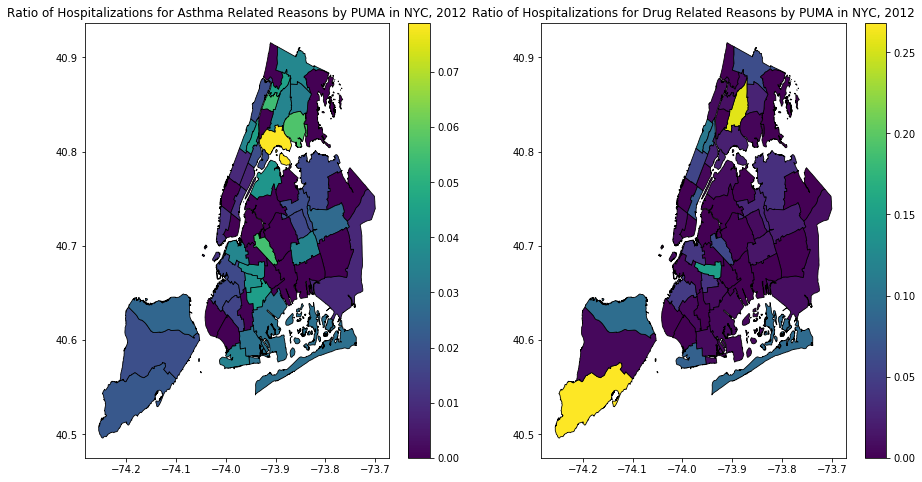

In [122]:
#plot health metrics on a heatmap
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(121)

puma_geo.plot(column='asthma_rat', cmap='viridis',linewidth=0.8, ax=ax,edgecolor='black',legend=True)

ax.axis('on')
ax.set_title("Ratio of Hospitalizations for Asthma Related Reasons by PUMA in NYC, 2012")

ax1 = fig.add_subplot(122)

puma_geo.plot(column='drug_rat', cmap='viridis',linewidth=0.8, ax=ax1,edgecolor='black',legend=True)

ax1.axis('on')
ax1.set_title("Ratio of Hospitalizations for Drug Related Reasons by PUMA in NYC, 2012")

### Figure 11: Shows the ratio of hospitalizations for both asthma and drug-related reasons by PUMA. While asthma shows wide variation across the city, drug related hospitalization are high in specific pockets of the city. Two areas of the city, southern Staten Island and the central Bronx have very high rates from drug-related hospitalizations, which is surprising in Staten Island and could be due to a very small denominator in total hospitalization and may contain a drug treatment center that heavily skews hospitalizations in that area. For asthma, the range for the ratio is much smaller, part of the reason for seeing the visual difference across the city. Some areas of the city, such as deeper parts of Brooklyn may have industrial activity that creates poor air quality, leading to higher rates, while areas of the Bronx may not have access to preventative medicine for asthma (e.g. prescription steroidal puffer) and so hospitalization rates for ashtma are higher, even though the local population may not have higher rates of asthma overall

Text(0.5,1,'Avg. Number of Property Crimes in Schools by PUMA in NYC, , 2013-14')

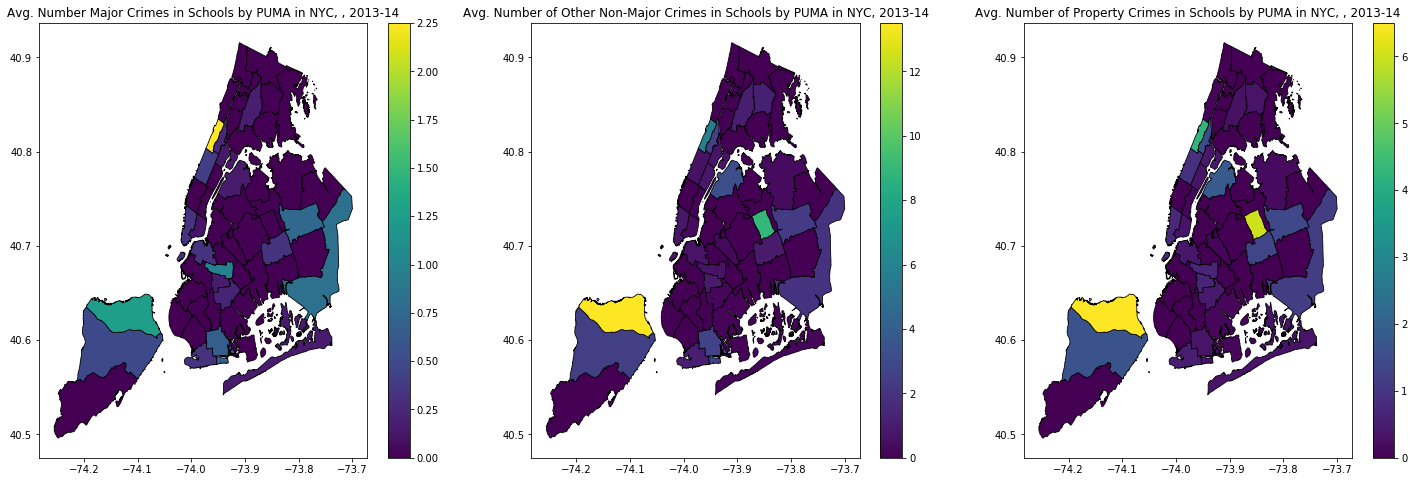

In [120]:
#plot crime metrics on a heatmap
fig = plt.figure(figsize=(25,8))
ax = fig.add_subplot(131)

puma_geo.plot(column='Major N', cmap='viridis',linewidth=0.8, ax=ax,edgecolor='black',legend=True)

ax.axis('on')
ax.set_title("Avg. Number Major Crimes in Schools by PUMA in NYC, , 2013-14")

ax1 = fig.add_subplot(132)

puma_geo.plot(column='Oth N', cmap='viridis',linewidth=0.8, ax=ax1,edgecolor='black',legend=True)

ax1.axis('on')
ax1.set_title("Avg. Number of Other Non-Major Crimes in Schools by PUMA in NYC, 2013-14")


ax2 = fig.add_subplot(133)

puma_geo.plot(column='Prop N', cmap='viridis',linewidth=0.8, ax=ax2,edgecolor='black',legend=True)

ax2.axis('on')
ax2.set_title("Avg. Number of Property Crimes in Schools by PUMA in NYC, , 2013-14")

### Figure 12: Compares three school crime statistics, average number of major crimes, average number of non-major crimes, and average number of property crimes. The values are averaged from individual schools by PUMA level. The areas where there are crime seem to be consistent across the three crime measures, albeit at different levels of severity, which implies there may be problem schools where there are high incidents of crime across all measures. Of course, much of the city has no school crime. High concentrations in Staten Island were particularly suprising.

Text(0.5,1,'Avg. Household Income by PUMA in NYC (2012, est)')

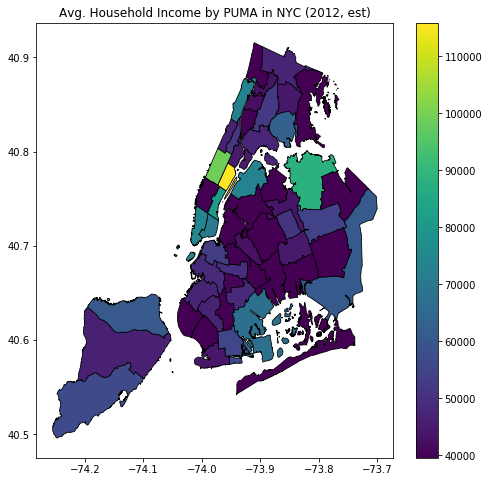

In [121]:
#plot income metrics on a heatmap
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

puma_geo.plot(column='Households; Estimate; Total', cmap='viridis',linewidth=0.8, ax=ax,edgecolor='black',legend=True)

ax.axis('on')
ax.set_title("Avg. Household Income by PUMA in NYC (2012, est)")

### Figure 13: Plots a heatmap of avg. household income by PUMA. As would be expected, high income PUMAs are concentrated in Manhattan, with lower income areas in Queen's, Brooklyn, and the Bronx. Note the median household income in the US is about 59,000 dollars, suggesting substantial parts of the Bronx and Queens in particular are below the national average.

## Linear Regression Modelling

In [130]:
#rename columns for regression input
puma_all.rename(columns={'Major N':'major_n','Oth N':'oth_n','NoCrim N':'nocrim_N','Prop N':'prop_n',
                 'Vio N':'vio_n','AvgofMajor N':'avg_majorn','AvgOfOth N':'avg_oth_n','AvgOfNoCrim N':'avg_nocrim',
                'AvgOfProp N':'avg_prop','AvgOfVio N':'avg_vio'},inplace=True)

puma_all.columns

Index(['puma', 'major_n', 'oth_n', 'nocrim_N', 'prop_n', 'vio_n',
       'AvgOfMajor N', 'avg_oth_n', 'avg_nocrim', 'avg_prop', 'avg_vio',
       'SAT Math Avg. Score', 'total_score', 'total', 'asthma', 'drugs',
       'asthma_rat', 'drug_rat', 'Households; Estimate; Total'],
      dtype='object')

In [131]:
#forgot two columns

puma_all.rename(columns={'AvgOfMajor N':'avg_major','SAT Math Avg. Score':'math_avg'},inplace=True)

puma_all.columns

Index(['puma', 'major_n', 'oth_n', 'nocrim_N', 'prop_n', 'vio_n', 'avg_major',
       'avg_oth_n', 'avg_nocrim', 'avg_prop', 'avg_vio', 'math_avg',
       'total_score', 'total', 'asthma', 'drugs', 'asthma_rat', 'drug_rat',
       'Households; Estimate; Total'],
      dtype='object')

In [134]:
#create a multivariate linear regression for the school crime variables
equation = 'total_score~major_n+oth_n+nocrim_N+prop_n+vio_n+avg_major+avg_oth_n+avg_nocrim+avg_prop+avg_vio'

crime_reg = smf.ols(formula=equation,data=puma_all).fit()
crime_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            total_score   R-squared:                       0.624
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     4.323
Date:                Sun, 16 Dec 2018   Prob (F-statistic):            0.00128
Time:                        11:58:39   Log-Likelihood:                -164.38
No. Observations:                  37   AIC:                             350.8
Df Residuals:                      26   BIC:                             368.5
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    382.1659      6.313     60.532      0.000       369.188   395.143
major_n      -88.8417     45.315     -1.961      0.061      -181.987     4.304
oth_n        -68.4009     33.299     -2.054      0.050      -136.847     0.045
nocrim_N       5.2746      4.791      1.101      0.281        -4.573    15.122
prop_n        87.7376     42.004      2.089      0.047         1.396   174.079
vio_n         86.3148     44.839      1.925      0.065        -5.853   178.483
avg_major    911.4918    350.438      2.601      0.015       191.156  1631.828
avg_oth_n    925.9713    301.218      3.074      0.005       306.809  1545.134
avg_nocrim  -119.9663     38.156     -3.144      0.004      -198.398   -41.535
avg_prop    -841.4544    270.713     -3.108      0.005     -1397.913  -284.996
avg_vio     -944.4367    363.696     -2.597      0.015     -1692.025  -196.848
==============================================================================
Omnibus:                        3.647   Durbin-Watson:                   1.421
Prob(Omnibus):                  0.161   Jarque-Bera (JB):                2.588
Skew:                           0.631   Prob(JB):                        0.274
Kurtosis:                       3.290   Cond. No.                     1.03e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.03e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### The r-squared from the model is relatively strong at 0.624 for a social sciences analysis. At a 95% confidence level (and in some cases 99% confidence level) we can reject the null hypothesis for many of the coefficient values, particularly the avg crime variables. We fail to reject the null for number of mjaor crimes, # of non-crime crimes, and number of of violent crimes. Note that the confidence intervals at the 95% level, particularly for major crimes and other crimes appear asymmetric, which contributes to the skewness value of 0.631, though this is not an extreme value for skeness (i.e. we do not need to be too worried about a asymmetric distribution for the model). 

#### Note, when viewing the beta values on individual coefficients we need to be cautious because as we saw above in the covariance matrix, there are various levels of colinearity between the independent variables that may invalidate the regression results and make the beta values difficult to interpret. I've printed the values of the covariance matrix below to illustrate. Though a "collinearity threshold" is not a hard line, there are clearly values that jump out, for example: Avg of Major Crimes has above a 0.99 correlation with the other average crime variables! In general, the average crime variables are strongly collinear (visually very clear from the covariance matrix above). 

#### This can sometimes be seen in the individual coefficent values where some coefficients are moving in the wrong direction than would be expected, for example the beta values on avg major and avg non-major crime. When we see this it's a strong indication that there are interaction affects happening between the independent variables

#### When levels of collinearity as high as some of these are present, the assumptions of a regression model, namely that independent variables are independent and that errors are independent and identically distributed is invalidated. the model becomes a prime candidate for dimensionality reduction - we can gain a better understanding of individual coefficient values and reduce complexity of the model.

In [135]:
school_corr

,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,SAT Math Avg. Score,total_score,total,asthma,drugs,asthma_rat,drug_rat,Households; Estimate; Total
Major N,1.000000,0.554556,0.543688,0.581519,0.711423,0.238941,0.216880,0.192896,0.220305,0.242761,0.197492,0.259018,-0.238536,-0.241808,0.021854,-0.004613,0.202426,-0.093852
Oth N,0.554556,1.000000,0.930418,0.964505,0.815522,0.739087,0.730117,0.682628,0.741970,0.753906,0.389164,0.427874,-0.165045,-0.206794,-0.015380,-0.073264,0.064096,-0.025580
NoCrim N,0.543688,0.930418,1.000000,0.838562,0.860173,0.722568,0.713398,0.667573,0.720479,0.744424,0.402563,0.454934,-0.185790,-0.259492,-0.057162,-0.104194,0.020294,-0.016557
Prop N,0.581519,0.964505,0.838562,1.000000,0.693781,0.752608,0.743576,0.698354,0.757047,0.759140,0.414335,0.448194,-0.179311,-0.221548,-0.044911,-0.088004,0.043954,-0.036335
Vio N,0.711423,0.815522,0.860173,0.693781,1.000000,0.379203,0.357720,0.333840,0.357891,0.406324,0.186410,0.242904,-0.154760,-0.168355,0.057742,-0.011393,0.165055,-0.019238
AvgOfMajor N,0.238941,0.739087,0.722568,0.752608,0.379203,1.000000,0.998309,0.983983,0.993922,0.998588,0.623978,0.655678,-0.208140,-0.346591,-0.196447,-0.168101,-0.174847,0.064403
AvgOfOth N,0.216880,0.730117,0.713398,0.743576,0.357720,0.998309,1.000000,0.982184,0.996926,0.997582,0.621754,0.650323,-0.213149,-0.345006,-0.194414,-0.164471,-0.170058,0.055665
AvgOfNoCrim N,0.192896,0.682628,0.667573,0.698354,0.333840,0.983983,0.982184,1.000000,0.965161,0.982899,0.615656,0.639505,-0.222295,-0.346821,-0.197696,-0.136385,-0.172054,0.104932
AvgOfProp N,0.220305,0.741970,0.720479,0.757047,0.357891,0.993922,0.996926,0.965161,1.000000,0.992625,0.612965,0.642377,-0.209392,-0.340625,-0.194590,-0.170356,-0.169007,0.035065
AvgOfVio N,0.242761,0.753906,0.744424,0.759140,0.406324,0.998588,0.997582,0.982899,0.992625,1.000000,0.619418,0.650425,-0.210156,-0.347787,-0.188182,-0.170584,-0.164746,0.064440


### add drugs and asthma discharge data to the multivariate linear regression

In [136]:
#Add in the health variables
equation = 'total_score~major_n+oth_n+nocrim_N+prop_n+vio_n+avg_major+avg_oth_n+avg_nocrim+avg_prop+avg_vio+asthma_rat+drug_rat'

crime_health_reg = smf.ols(formula=equation,data=puma_all).fit()
crime_health_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            total_score   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     7.152
Date:                Sun, 16 Dec 2018   Prob (F-statistic):           2.39e-05
Time:                        12:43:15   Log-Likelihood:                -154.36
No. Observations:                  37   AIC:                             334.7
Df Residuals:                      24   BIC:                             355.7
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    409.1622      9.311     43.942      0.000       389.945   428.380
major_n      -97.0946     37.104     -2.617      0.015      -173.673   -20.516
oth_n        -70.5241     27.210     -2.592      0.016      -126.683   -14.365
nocrim_N       5.2878      3.862      1.369      0.184        -2.682    13.258
prop_n        89.8564     34.146      2.632      0.015        19.383   160.330
vio_n         98.8318     36.260      2.726      0.012        23.994   173.669
avg_major    956.1409    286.831      3.333      0.003       364.151  1548.130
avg_oth_n    958.1425    240.400      3.986      0.001       461.982  1454.303
avg_nocrim  -110.0046     30.666     -3.587      0.001      -173.296   -46.713
avg_prop    -820.9453    216.065     -3.800      0.001     -1266.881  -375.009
avg_vio    -1130.6755    295.474     -3.827      0.001     -1740.503  -520.848
asthma_rat  -888.9142    215.426     -4.126      0.000     -1333.532  -444.297
drug_rat      28.3459     58.197      0.487      0.631       -91.767   148.459
==============================================================================
Omnibus:                        5.252   Durbin-Watson:                   2.151
Prob(Omnibus):                  0.072   Jarque-Bera (JB):                3.923
Skew:                           0.754   Prob(JB):                        0.141
Kurtosis:                       3.520   Cond. No.                     1.05e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.05e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Our R2, skewness, and kurtosis all increased from adding in the health variables, however we reject the null hypothesis for drug ratio at the 95% confidence level. We can now reject the null for almost all of the crime variables, with the exception of non-crime crime number. The skewness and kurtosis values are 

#### Note that my comments about collinearity above still hold for this regression and dimensonality reduction should be conducted. All of the comments about coefficient values hold for this regression as well, though some of the interaction affects between independent variables have changed.

### Add in the income data

In [137]:
#rename income variable

puma_all.rename(columns={'Households; Estimate; Total':'hh_income'},inplace=True)

In [138]:
#Add in the health variables
equation = 'total_score~major_n+oth_n+nocrim_N+prop_n+vio_n+avg_major+avg_oth_n+avg_nocrim+avg_prop+avg_vio+asthma_rat+drug_rat+hh_income'

all_reg = smf.ols(formula=equation,data=puma_all).fit()
all_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            total_score   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     7.299
Date:                Sun, 16 Dec 2018   Prob (F-statistic):           2.10e-05
Time:                        12:55:22   Log-Likelihood:                -152.27
No. Observations:                  37   AIC:                             332.5
Df Residuals:                      23   BIC:                             355.1
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    379.4620     20.007     18.967      0.000       338.075   420.849
major_n     -100.7975     35.883     -2.809      0.010      -175.026   -26.569
oth_n        -75.8346     26.457     -2.866      0.009      -130.566   -21.104
nocrim_N       5.8180      3.741      1.555      0.134        -1.921    13.557
prop_n        96.4893     33.199      2.906      0.008        27.812   165.167
vio_n        102.5496     35.070      2.924      0.008        30.001   175.098
avg_major    960.5581    276.867      3.469      0.002       387.816  1533.300
avg_oth_n    992.2988    232.947      4.260      0.000       510.412  1474.185
avg_nocrim  -117.5665     29.947     -3.926      0.001      -179.517   -55.616
avg_prop    -845.5965    209.077     -4.044      0.001     -1278.104  -413.089
avg_vio    -1144.9564    285.326     -4.013      0.001     -1735.197  -554.716
asthma_rat  -670.6032    245.964     -2.726      0.012     -1179.419  -161.788
drug_rat      40.3725     56.637      0.713      0.483       -76.790   157.535
hh_income      0.0004      0.000      1.662      0.110     -9.34e-05     0.001
==============================================================================
Omnibus:                        0.778   Durbin-Watson:                   2.328
Prob(Omnibus):                  0.678   Jarque-Bera (JB):                0.763
Skew:                           0.314   Prob(JB):                        0.683
Kurtosis:                       2.683   Cond. No.                     8.93e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.93e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""



#### Our r2 has gone up to approx. 0.8 by adding in income which is an improvement. Note that generally speaking, adding more variables is going to reduce the residual error in the model and is going to improve your r2 regardless, so it's not necessarily a large improvement. We also fail to reject the null hypothesis at a 95% confidence level for household income. For the most part, our other coefficients still fail to be rejected. Skewness has been reduced which is positive.

### LR tests for goodness of fit and complexity comparison

In [139]:
#Run log likelihood test
crime_health_reg.compare_lr_test(crime_reg)

(20.036639641015086, 4.4575783354896242e-05, 2.0)

In [140]:
#run log likelihood test
all_reg.compare_lr_test(crime_health_reg)

(4.1944802428642447, 0.040555783534823898, 1.0)

## random forest regression

In [160]:
#drop remaining nan's from crime data
puma_all.dropna(inplace=True)
puma_all.head()

,puma,major_n,oth_n,nocrim_N,prop_n,vio_n,avg_major,avg_oth_n,avg_nocrim,avg_prop,avg_vio,math_avg,total_score,total,asthma,drugs,asthma_rat,drug_rat,hh_income
1,3702,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,378.555556,374.740741,15889.0,580.0,990.0,0.036503,0.062307,47061
3,3704,0.000000,1.166667,0.833333,0.333333,0.666667,0.055000,0.220000,0.293333,0.138333,0.098333,412.666667,404.611111,51099.0,1704.0,1308.0,0.033347,0.025597,44207
4,3705,0.185185,1.111111,1.296296,0.296296,0.592593,0.061852,0.234815,0.301111,0.150000,0.105926,378.222222,373.629630,25502.0,910.0,6535.0,0.035683,0.256254,52247
6,3707,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,365.000000,356.833333,24810.0,1351.0,284.0,0.054454,0.011447,42497
8,3709,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,372.250000,364.111111,4631.0,264.0,15.0,0.057007,0.003239,62730


In [173]:
#first split our data into x and y arrays
X = puma_all[['major_n','oth_n','nocrim_N','prop_n','vio_n','avg_major',
                      'avg_oth_n','avg_nocrim','avg_prop','avg_vio']]


y = puma_all['total_score']

In [174]:
# next apply standardization to feature data
scaler = StandardScaler()
X_scal = scaler.fit_transform(X)

In [175]:
#next, train test split the data so we can create validation metrics
X_train, X_test, y_train, y_test = train_test_split(X_scal, y, test_size=0.2, random_state=13)

In [176]:
#initialize random forest regressor model
randf_reg = RandomForestRegressor(max_depth=10, random_state=13, n_estimators=100)

#fit the model on training data
randf_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=13,
           verbose=0, warm_start=False)

In [177]:
#calculate prediction on test data
randf_pred = randf_reg.predict(X_test)

In [178]:
#calcuate the R2 metric for the regression, here I calculate in and out of sample 

print("the in-sample (i.e train sample) R2 is {}".format(randf_reg.score(X_train, y_train)))
print("the out of sample (i.e. test sample) R2 is {}".format(randf_reg.score(X_test, y_test)))

the in-sample (i.e train sample) R2 is 0.8524340442914455
the out of sample (i.e. test sample) R2 is 0.5939763779756292


####  Based on r2 values the random forest regressor is out performing the basic OLS in-sample (training) and still doing fairly well out-of-sample, almost improving on the original regression (which was not train-test-split). If we increase the depth and number of estimators, we may improve the results marginally, however, the benefit of additional tree splits may be mitigated by the fact that we have highly collinear feature variables

### Measure feature importance for dimensionality reduction

In [183]:
#match the features to the columns so I can pick out the three most important
feature_importances = pd.DataFrame(randf_reg.feature_importances_, index=X.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

In [184]:
#printing important features by value
feature_importances

,importance
avg_major,0.208079
avg_nocrim,0.183032
avg_vio,0.142715
avg_prop,0.125129
avg_oth_n,0.069053
prop_n,0.065735
major_n,0.061284
vio_n,0.061079
nocrim_N,0.045396
oth_n,0.038499


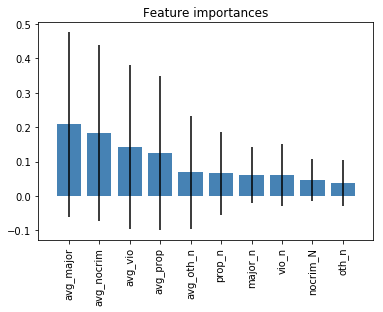

In [185]:
#visualizing using the professors function
featureImportancePlot(randf_reg,X.columns)

### The three most important features are average of major crimes, average of non-crime crimes, and average of violent crimes

### Repeat the process

In [186]:
#first split our data into x and y arrays
X = puma_all[['avg_major','avg_nocrim','avg_vio','asthma_rat','drug_rat','hh_income']]

y = puma_all['total_score']

In [187]:
#standardize your feature inputs
# next apply standardization to feature data
scaler = StandardScaler()
X_scal = scaler.fit_transform(X)

In [188]:
#next, train test split the data so we can create validation metrics
X_train, X_test, y_train, y_test = train_test_split(X_scal, y, test_size=0.2, random_state=13)

In [189]:
#initialize random forest regressor model
randf_reg = RandomForestRegressor(max_depth=10, random_state=13, n_estimators=100)

#fit the model on training data
randf_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=13,
           verbose=0, warm_start=False)

In [190]:
#calculate prediction on test data
randf_pred = randf_reg.predict(X_test)

### 11.2 evaluate the performance of the model (3 points)

In [191]:
#calcuate the R2 metric for the regression, here I calculate in and out of sample 

print("the in-sample (i.e train sample) R2 is {}".format(randf_reg.score(X_train, y_train)))
print("the out of sample (i.e. test sample) R2 is {}".format(randf_reg.score(X_test, y_test)))

the in-sample (i.e train sample) R2 is 0.9098557704015058
the out of sample (i.e. test sample) R2 is 0.8010842590506706


#### strong improvement from performing dimensionality reduction and adding in health and income variables for additional explantory power! In same is still quite high, at 0.9, but out-of-sample (test R2) has risen to 0.8 even though the model is simpler than the first random forest regressor (degree of freedom difference of 4). 

In [192]:
#match the features to the columns so I can pick out the three most important
feature_importances = pd.DataFrame(randf_reg.feature_importances_, index=X.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

In [193]:
feature_importances

,importance
avg_nocrim,0.212157
avg_major,0.207764
asthma_rat,0.170394
avg_vio,0.142864
hh_income,0.140343
drug_rat,0.126478


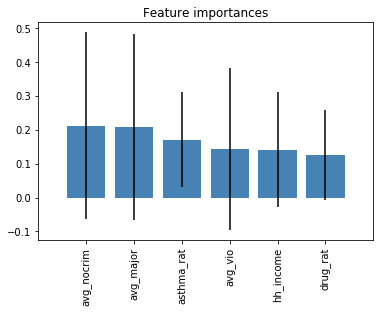

In [194]:
#visualizing using the professors function
featureImportancePlot(randf_reg,X.columns)

#### The importance of the features highlights the improved predictability of the reduced dimension regression. All features, even the "least" important, have high scores than the variables that were excluded (the other crime variables). We also aren't seeing a steep drop off in the importance of the regressors like we did in the first regression, implying it probably makes sense to keep all six. Perhaps extending the analysis to other cities to improve sample size might change the feature selection results, but based on New York this appers to be the best model for predicting total SAT score average based on school crime and health factors